<a href="https://colab.research.google.com/github/sridevibonthu/NVIDIA/blob/main/FDPDay4/2news_class_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Text Classification (AG News)

This notebook demonstrates fine-tuning a pre-trained BERT model from the Hugging Face `transformers` library for a text classification task using the AG News dataset. It includes:

1.  **Setup:** Installation, imports, configuration.
2.  **Data Handling:** Loading, exploring, and preprocessing the AG News dataset.
3.  **Tokenization:** Using BERT's tokenizer and visualizing its output.
4.  **Model Loading:** Loading `BertForSequenceClassification`.
5.  **Model Visualization:** Displaying the BERT model architecture.
6.  **Fine-tuning:** Training the model on the dataset.
7.  **Evaluation:** Assessing performance with accuracy, classification report, and confusion matrix.
8.  **Prediction:** Example of predicting a single sentence.

**Goal:** Complete within ~10-15 minutes on a standard Google Colab GPU instance (adjustments made for BERT's computational cost).

## Section 1: Installation

Install necessary libraries if they are not already available in the Colab environment.
- `datasets`: For loading datasets easily.
- `transformers`: For pre-trained models (like BERT) and tokenizers.
- `scikit-learn`: For evaluation metrics.
- `accelerate`: Often helpful for optimizing PyTorch training, especially with Transformers.
- `pandas`: For data manipulation and visualization.
- `seaborn` & `matplotlib`: For plotting.

In [ ]:
# -*- coding: utf-8 -*-
print("--- Section 1: Installing required packages ---")
!pip install torch datasets transformers scikit-learn accelerate pandas seaborn matplotlib -q
print("Installation complete.\n")

--- Section 1: Installing required packages ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 

## Section 2: Imports

Import all necessary libraries for the notebook. We specifically import `AdamW` which is often recommended for Transformer models.

In [ ]:
print("--- Section 2: Importing libraries ---")
import torch
import torch.nn as nn
# Import AdamW from transformers
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
# Import the specific BERT model for sequence classification and the tokenizer
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print("Imports complete.\n")

--- Section 2: Importing libraries ---
Imports complete.



## Section 3: Setup and Configuration

Set up the environment, define constants, and start the timer.
**NOTE:** Reduced `BATCH_SIZE`, `EPOCHS`, and `LEARNING_RATE` as BERT fine-tuning is more resource-intensive and sensitive.

In [ ]:
# Start timer to track execution time.
start_time = time.time()

# Set device to GPU (cuda) if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Configuration parameters
MODEL_NAME = "bert-base-uncased" # Use BERT pre-trained weights and tokenizer
DATASET_NAME = "ag_news"
MAX_LENGTH = 128 # Max sequence length for tokenizer
BATCH_SIZE = 32 # Reduced batch size for BERT on Colab
LEARNING_RATE = 2e-5 # Lower learning rate is common for fine-tuning BERT
EPOCHS = 2 # Reduced epochs as BERT fine-tuning converges faster (and saves time)
TRAIN_SUBSET_SIZE = 10000 # Use a subset for faster training
TEST_SUBSET_SIZE = 1000 # Use a subset for faster evaluation

print("Setup complete.\n")
print(f"NOTE: Using BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}, LR={LEARNING_RATE} for BERT fine-tuning.")

Setup complete.

NOTE: Using BATCH_SIZE=32, EPOCHS=2, LR=2e-05 for BERT fine-tuning.


## Section 4: Load Dataset

Load the AG News dataset using the `datasets` library. We use subsets for faster execution.

In [ ]:
# Load subsets of the train and test splits
dataset = load_dataset(DATASET_NAME, split={
    'train': f'train[:{TRAIN_SUBSET_SIZE}]',
    'test': f'test[:{TEST_SUBSET_SIZE}]'
})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Define the mapping from label index to label name
# AG News class labels: 0: World, 1: Sports, 2: Business, 3: Sci/Tech
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(dataset['train'].unique("label"))

print(f"Dataset loaded.")
print(f"Number of training examples: {len(dataset['train'])}")
print(f"Number of test examples: {len(dataset['test'])}")
print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_map}\n")

Dataset loaded.
Number of training examples: 10000
Number of test examples: 1000
Number of classes: 4
Class labels: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}



## Section 5: Explore the Data

Display a few examples from the training set using Pandas for a clear view.

In [ ]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 10000
})

In [ ]:
dataset['train'][10]

{'text': "Oil and Economy Cloud Stocks' Outlook  NEW YORK (Reuters) - Soaring crude prices plus worries  about the economy and the outlook for earnings are expected to  hang over the stock market next week during the depth of the  summer doldrums.",
 'label': 2}

In [ ]:
# Create a Pandas DataFrame for better display
df_samples = pd.DataFrame(dataset['train'][:5]) # Show first 5 samples
# Add a column with the readable label name
df_samples['label_name'] = df_samples['label'].map(label_map)
# Display relevant columns
print(df_samples[['text', 'label', 'label_name']])
print("\n")

                                                text  label label_name
0  Wall St. Bears Claw Back Into the Black (Reute...      2   Business
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   Business
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   Business
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   Business
4  Oil prices soar to all-time record, posing new...      2   Business




## Section 6: Load Tokenizer

Load the tokenizer corresponding to the chosen model (`bert-base-uncased`). This tokenizer converts text into numerical IDs suitable for BERT.

In [ ]:
print(f"--- Section 6: Loading tokenizer '{MODEL_NAME}' ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded.")
# Display special tokens and their IDs
print(f"Padding token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
print(f"CLS token: '{tokenizer.cls_token}', ID: {tokenizer.cls_token_id}")
print(f"SEP token: '{tokenizer.sep_token}', ID: {tokenizer.sep_token_id}")
print("\n")

--- Section 6: Loading tokenizer 'bert-base-uncased' ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded.
Padding token: '[PAD]', ID: 0
CLS token: '[CLS]', ID: 101
SEP token: '[SEP]', ID: 102




In [ ]:
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 7592, 1010, 2129, 2024, 2017, 1029, 2129,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
inputs = tokenizer(["Hello, how are you?", "I am fine.", "I am learning NLP."], return_tensors="pt", padding=True, truncation=True)
inputs


{'input_ids': tensor([[  101,  7592,  1010,  2129,  2024,  2017,  1029,   102],
        [  101,  1045,  2572,  2986,  1012,   102,     0,     0],
        [  101,  1045,  2572,  4083, 17953,  2361,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])}

## Section 7: Tokenization Example Visualization

Show how a sample sentence is processed by the tokenizer: converted into tokens (subwords), mapped to Input IDs, padded/truncated, and assigned an Attention Mask.

In [ ]:
print("--- Section 7: Tokenization Example ---")
sample_text = "Here is a sample sentence to visualize tokenization."
print(f"Original Text: '{sample_text}'")

# Tokenize the sample text
encoding = tokenizer(sample_text, max_length=MAX_LENGTH, padding='max_length', truncation=True)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Create a DataFrame for better visualization
token_df = pd.DataFrame({
    'Token': tokens,
    'Input ID': input_ids,
    'Attention Mask': attention_mask
})

# Display the DataFrame, showing only the relevant part before padding dominates
try:
    first_pad_index = input_ids.index(tokenizer.pad_token_id)
    print(f"(Showing tokens up to the first padding token, index {first_pad_index})")
    print(token_df.iloc[:first_pad_index + 2])
except ValueError:
     print("(Showing all tokens)")
     print(token_df)
print("\n")

--- Section 7: Tokenization Example ---
Original Text: 'Here is a sample sentence to visualize tokenization.'
(Showing tokens up to the first padding token, index 13)
        Token  Input ID  Attention Mask
0       [CLS]       101               1
1        here      2182               1
2          is      2003               1
3           a      1037               1
4      sample      7099               1
5    sentence      6251               1
6          to      2000               1
7      visual      5107               1
8       ##ize      4697               1
9       token     19204               1
10  ##ization      3989               1
11          .      1012               1
12      [SEP]       102               1
13      [PAD]         0               0
14      [PAD]         0               0




## Section 8: Preprocessing

Define the function to tokenize the dataset examples and apply it to the entire dataset using `.map()`. Set the format to PyTorch tensors and rename the `label` column to `labels` for compatibility with Hugging Face models.

In [ ]:
print("--- Section 8: Preprocessing Dataset ---")
# Define a function to tokenize the text data.
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

# Apply the preprocessing function to the dataset.
print("Applying tokenization to the dataset...")
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Rename 'label' to 'labels' for Hugging Face model compatibility
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Set the format to PyTorch tensors for columns needed by the model.
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# Separate the processed train and test sets
train_dataset = encoded_dataset['train']
test_dataset = encoded_dataset['test']
print("Preprocessing complete. Dataset formatted for PyTorch.")
# Check column names:
print(f"Train dataset columns: {train_dataset.column_names}")
print(f"Test dataset columns: {test_dataset.column_names}")
print("\n")

--- Section 8: Preprocessing Dataset ---
Applying tokenization to the dataset...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Preprocessing complete. Dataset formatted for PyTorch.
Train dataset columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']
Test dataset columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']




## Section 9: Create DataLoaders

Create PyTorch DataLoaders to handle batching and shuffling of the data.

In [ ]:
print("--- Section 9: Creating DataLoaders ---")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# For evaluation, keep the same structure for simplicity
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")
print("\n")

--- Section 9: Creating DataLoaders ---
DataLoaders created with batch size 32.
Number of batches in train_dataloader: 313
Number of batches in test_dataloader: 32




## Section 10: Load Pre-trained Model

Load a pre-trained BERT model with a sequence classification head (`BertForSequenceClassification`). The base BERT weights are pre-trained, but the classification head is initialized randomly and needs fine-tuning.

In [ ]:
# Load the BertForSequenceClassification model
# - MODEL_NAME specifies the BERT variant (bert-base-uncased)
# - num_labels tells the model how many output classes the classification head should have.
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes
)

# Move the model to the designated device
model.to(device)

print(f"Loaded '{MODEL_NAME}' for sequence classification with {num_classes} labels.")
print("The final classification layer weights are randomly initialized and need fine-tuning.\n")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded 'bert-base-uncased' for sequence classification with 4 labels.
The final classification layer weights are randomly initialized and need fine-tuning.



## Section 11: Instantiate Optimizer

Define the optimizer. `AdamW` is generally preferred for Transformer models. The loss function (CrossEntropyLoss) is typically calculated *inside* the Hugging Face model's forward pass when labels are provided.

In [ ]:
print("--- Section 11: Instantiating Optimizer ---")

# Define the optimizer (AdamW recommended for Transformers)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print("Optimizer (AdamW) instantiated.")
print("Loss calculation will be handled by the model during the forward pass when labels are provided.\n")

--- Section 11: Instantiating Optimizer ---
Optimizer (AdamW) instantiated.
Loss calculation will be handled by the model during the forward pass when labels are provided.



## Section 12: Visualize Model Structure

Print the model's architecture (BERT + classification head) and the total number of trainable parameters. Expect ~110 million for `bert-base-uncased`.

In [ ]:
print("--- Section 12: Model Architecture (BERT) ---")
# Print the model structure - this will be quite long!
print(model)

# Calculate and print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")
print("Note: Most parameters are in the BERT layers (embeddings, encoders).")
print("      The 'classifier' layer at the end is the fine-tuning head.\n")

--- Section 12: Model Architecture (BERT) ---
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

## Section 13: Training Loop (Fine-tuning BERT)

Train (fine-tune) the BERT model. The forward pass takes the batch dictionary directly. The model output contains the loss when `labels` are provided.

In [ ]:
print("--- Section 13: Starting Training (Fine-tuning BERT) ---")
model.train() # Set the model to training mode

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    epoch_loss = 0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Iterate over batches in the training data loader
    for i, batch in enumerate(train_dataloader):
        # Move batch data to the configured device
        batch = {k: v.to(device) for k, v in batch.items()}

        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass: Pass the batch directly to the model.
        # Since 'labels' are in the batch, the model calculates the loss internally.
        outputs = model(**batch)

        # 3. Get the loss from the model output
        loss = outputs.loss

        # 4. Backward pass: Compute gradients
        loss.backward()

        # 5. Optimizer step: Update model weights
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

        # Print progress periodically
        if (i + 1) % 20 == 0: # Print more frequently if needed
             print(f"  Batch {i+1}/{len(train_dataloader)}, Batch Loss: {loss.item():.4f}")

    # Calculate and print average loss for the epoch
    epoch_end_time = time.time()
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Average Training Loss: {avg_epoch_loss:.4f}")

print("\n--- Training Finished ---")

--- Section 13: Starting Training (Fine-tuning BERT) ---

Epoch 1/2
  Batch 20/313, Batch Loss: 1.1101
  Batch 40/313, Batch Loss: 0.6389
  Batch 60/313, Batch Loss: 0.3434
  Batch 80/313, Batch Loss: 0.5224
  Batch 100/313, Batch Loss: 0.4071
  Batch 120/313, Batch Loss: 0.2748
  Batch 140/313, Batch Loss: 0.5338
  Batch 160/313, Batch Loss: 0.2467
  Batch 180/313, Batch Loss: 0.2836
  Batch 200/313, Batch Loss: 0.3535
  Batch 220/313, Batch Loss: 0.2757
  Batch 240/313, Batch Loss: 0.3746
  Batch 260/313, Batch Loss: 0.0530
  Batch 280/313, Batch Loss: 0.3975
  Batch 300/313, Batch Loss: 0.3517
Epoch 1 completed in 194.91 seconds.
Average Training Loss: 0.4289

Epoch 2/2
  Batch 20/313, Batch Loss: 0.1557
  Batch 40/313, Batch Loss: 0.5731
  Batch 60/313, Batch Loss: 0.2514
  Batch 80/313, Batch Loss: 0.1765
  Batch 100/313, Batch Loss: 0.1509
  Batch 120/313, Batch Loss: 0.1896
  Batch 140/313, Batch Loss: 0.0622
  Batch 160/313, Batch Loss: 0.0746
  Batch 180/313, Batch Loss: 0.085

## Section 14: Evaluation

Evaluate the fine-tuned BERT model on the test dataset. Get logits from the model output and calculate metrics like accuracy, classification report, and confusion matrix.


--- Section 14: Starting Evaluation ---

--- Evaluation Results ---
Test Accuracy: 0.9280

Classification Report:
              precision    recall  f1-score   support

       World     0.9611    0.9216    0.9410       268
      Sports     0.9781    0.9781    0.9781       274
    Business     0.8585    0.8585    0.8585       205
    Sci/Tech     0.8977    0.9368    0.9168       253

    accuracy                         0.9280      1000
   macro avg     0.9239    0.9238    0.9236      1000
weighted avg     0.9287    0.9280    0.9281      1000


Confusion Matrix:


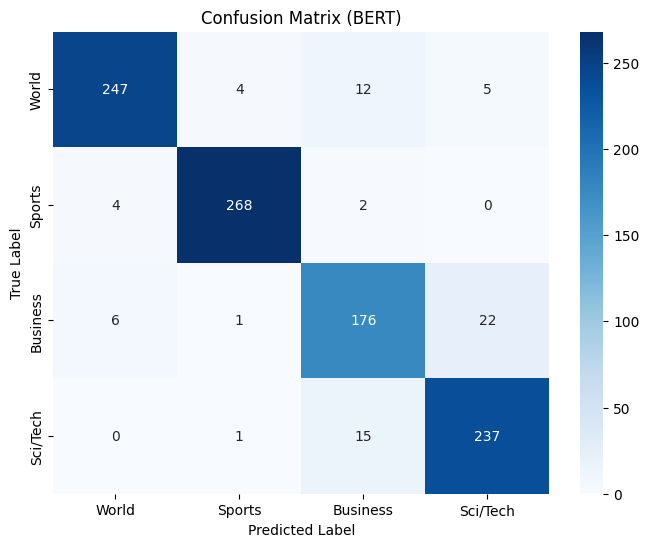


--- Evaluation Finished ---


In [ ]:
print("\n--- Section 14: Starting Evaluation ---")
model.eval() # Set the model to evaluation mode

all_preds = []
all_labels = []

# Disable gradient calculations
with torch.no_grad():
    # Iterate over batches in the test data loader
    for batch in test_dataloader:
        # Store true labels (on CPU)
        batch_labels = batch['labels'].cpu().numpy()
        all_labels.extend(batch_labels)

        # Move batch data to the device (input_ids, attention_mask)
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        # Forward pass: Get model outputs (logits)
        outputs = model(**batch_inputs)
        logits = outputs.logits

        # Get predictions by finding the class with the highest logit score
        predictions = torch.argmax(logits, dim=1)

        # Move predictions to CPU and store them
        all_preds.extend(predictions.cpu().numpy())


# Calculate metrics using scikit-learn
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=label_map.values(), digits=4)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n--- Evaluation Results ---")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Plot Confusion Matrix
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT)')
plt.show()

print("\n--- Evaluation Finished ---")

## Section 15: Final Timings

Calculate and print the total execution time for the entire notebook.

In [ ]:
print("\n--- Section 15: Final Timings ---")
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes).")
print("(Note: Fine-tuning BERT takes significantly longer than the simple model.)\n")


--- Section 15: Final Timings ---
Total execution time: 575.52 seconds (9.59 minutes).
(Note: Fine-tuning BERT takes significantly longer than the simple model.)



## Section 16: Optional: Example Prediction (BERT)

Demonstrate how to use the fine-tuned BERT model to predict the class for a single, new sentence.

In [ ]:
print("\n--- Section 16: Example Prediction (BERT) ---")
# Define a new sentence
text = "The latest space mission successfully launched yesterday evening."
print(f"Input Sentence: '{text}'")

model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradients
    # 1. Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LENGTH)

    # 2. Move tokenized inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Get model output (logits)
    # Pass inputs directly using dictionary unpacking **inputs
    outputs = model(**inputs)
    logits = outputs.logits

    # 4. Get the predicted class index
    prediction_idx = torch.argmax(logits, dim=1).item()

    # 5. Map the predicted index back to the readable label name
    predicted_label = label_map.get(prediction_idx, 'Unknown')

    print(f"Predicted class index: {prediction_idx}")
    print(f"Predicted label: {predicted_label}")
print("\n--- End of Notebook ---")


--- Section 16: Example Prediction (BERT) ---
Input Sentence: 'The latest space mission successfully launched yesterday evening.'
Predicted class index: 3
Predicted label: Sci/Tech

--- End of Notebook ---
